<a href="https://colab.research.google.com/github/dwiiittt/PACD_Project/blob/main/detect_tb_dwi%20gusna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.feature import graycomatrix, graycoprops, blob_log
from skimage.filters import gabor
from skimage import measure
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Path ke file zip di Google Drive Anda
zip_path = "/content/drive/My Drive/DatasetProposal.zip"

# Folder tujuan untuk mengekstrak dataset
dataset_path = "DatasetProposal"

# Membuat folder tujuan jika belum ada
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# Mengekstrak file zip
print(f"Mengekstrak '{zip_path}'...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)
print("Dataset berhasil diekstrak.")

Mengekstrak '/content/drive/My Drive/DatasetProposal.zip'...
Dataset berhasil diekstrak.


In [ ]:
base_folder = os.path.join(dataset_path,'DatasetProposal/TB_Chest_Radiography_Database') # <-- Path dasar baru

normal_path = os.path.join(base_folder, 'Normal') # <-- Nama folder normal yang benar
tbc_path = os.path.join(base_folder, 'Tuberculosis')       # <-- Nama folder TBC yang benar

# Cek apakah folder ada dan hitung jumlah file
if os.path.exists(normal_path) and os.path.exists(tbc_path):
    print(f"Jumlah gambar normal: {len(os.listdir(normal_path))}")
    print(f"Jumlah gambar TBC: {len(os.listdir(tbc_path))}")
else:
    print("Error: Path ke folder gambar tidak ditemukan. Periksa kembali nama folder.")
    print(f"Mencari di path normal: {normal_path}")
    print(f"Mencari di path TBC: {tbc_path}")

Jumlah gambar normal: 3500
Jumlah gambar TBC: 700


Memproses: Hybrid V4 (Smart Anti-Leak + Fallback)...


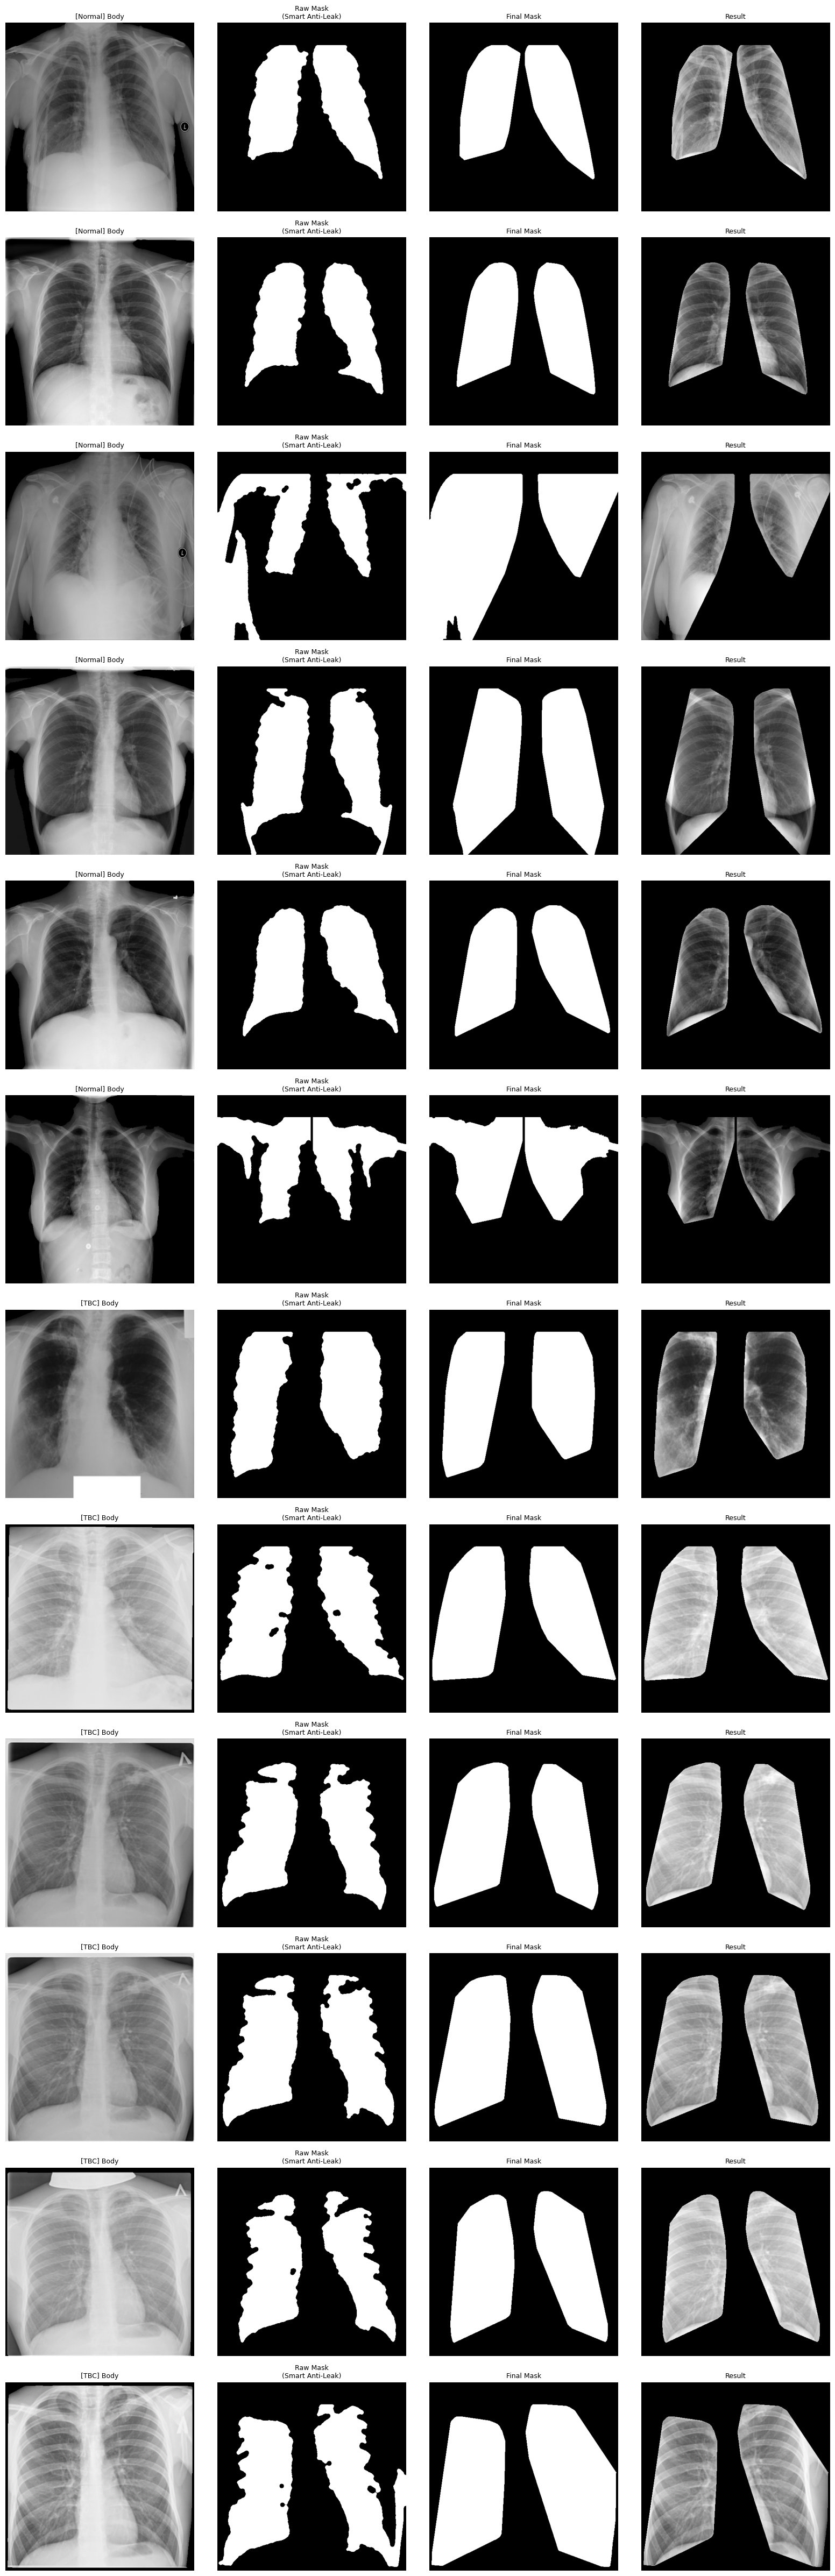

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from skimage import measure, morphology, exposure, filters, segmentation
from scipy import ndimage

# ==========================================
# 1. BODY SEGMENTATION (TETAP SAMA)
# ==========================================
def segment_body_robust(image_path, threshold=20):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)

    binary = img_array > threshold
    label_img = measure.label(binary)
    regions = measure.regionprops(label_img)

    if not regions:
        return img_array, np.zeros_like(img_array), img_array

    largest_region = max(regions, key=lambda x: x.area)
    body_mask = np.zeros_like(binary)
    for coords in largest_region.coords:
        body_mask[coords[0], coords[1]] = 1

    body_mask_filled = ndimage.binary_fill_holes(body_mask)
    body_mask_eroded = morphology.binary_erosion(body_mask_filled, morphology.disk(3))

    segmented_body = img_array.copy()
    segmented_body[body_mask_eroded == 0] = 0

    return img_array, body_mask_eroded, segmented_body

# ==========================================
# 2. SEGMENTASI PARU "HYBRID V4: SMART FALLBACK"
# ==========================================

def segment_lungs_smart_fallback(img_input, body_mask):
    rows, cols = img_input.shape

    # A. PREPROCESSING (Gamma 1.5)
    img_float = img_input.astype(float)
    img_gamma = 255 * (img_float / 255) ** 1.5
    img_gamma = img_gamma.astype(np.uint8)

    # B. THRESHOLDING & FAILSAFE
    pixels_in_body = img_gamma[body_mask > 0]
    if len(pixels_in_body) == 0:
        # Fallback Ekstrim: Kalau body kosong, return kosong
        return img_input, np.zeros_like(body_mask), np.zeros_like(body_mask), img_input

    mean_val = np.mean(pixels_in_body)
    std_val = np.std(pixels_in_body)
    thresh_val = mean_val - (0.3 * std_val)
    binary = (img_gamma < thresh_val) & (body_mask > 0)

    # Cek apakah threshold terlalu ketat (hasil terlalu sedikit)
    if np.sum(binary) < (np.sum(body_mask) * 0.05):
        thresh_val = np.percentile(pixels_in_body, 45)
        binary = (img_gamma < thresh_val) & (body_mask > 0)

    # ========================================================
    # C. SMART ANTI-LEAK (REVISI)
    # ========================================================

    # 1. Neck Cut (Selalu aman dilakukan)
    cutoff_row = int(rows * 0.12)
    binary[:cutoff_row, :] = 0

    # 2. Smart Border Clearing
    # Kita coba hapus border. Tapi kalau hasilnya malah habis (hitam), kita batalkan.
    binary_original = binary.copy()

    # Tambah padding biar clear_border bekerja aman
    binary_padded = np.pad(binary, ((0, 1), (0, 0)), mode='constant')
    binary_cleared = segmentation.clear_border(binary_padded, buffer_size=1)
    binary_cleared = binary_cleared[:-1, :] # Hapus padding

    original_area = np.sum(binary)
    cleared_area = np.sum(binary_cleared)

    # SAFETY CHECK:
    # Jika kita kehilangan > 50% area setelah clear border,
    # Berarti paru-paru itu menyentuh pinggir. JANGAN DIHAPUS.
    if original_area > 0 and (cleared_area / original_area) < 0.5:
        # Revert ke binary awal (tetap ada Neck Cut, tapi pinggir dibiarkan)
        # Kita andalkan Convex Hull clipping nanti untuk merapikan pinggir
        binary = binary_original
    else:
        # Aman, pakai yang sudah dibersihkan
        binary = binary_cleared

    # ========================================================
    # D. MORPHOLOGY & HULL
    # ========================================================

    # Closing (Lem TBC)
    binary = morphology.binary_closing(binary, morphology.disk(6))

    # Opening (Gunting Halus)
    binary = morphology.binary_opening(binary, morphology.disk(4))

    # Trachea Split
    mid_col = cols // 2
    binary[:, mid_col-3 : mid_col+3] = 0

    # Filter Objek
    label_img = measure.label(binary)
    regions = measure.regionprops(label_img)

    candidates = []
    for r in regions:
        if r.area < 500: continue
        if r.centroid[0] < (rows * 0.12): continue
        candidates.append(r)

    candidates.sort(key=lambda x: x.area, reverse=True)
    top_regions = candidates[:2]

    mask_convex_combined = np.zeros_like(binary)
    mask_raw = np.zeros_like(binary)

    # Jika kandidat kosong (masih hitam), pakai Fallback Terakhir
    # Ambil Body Mask, kecilkan, anggap itu paru-paru (Better than nothing)
    if not top_regions:
        print("⚠️ Warning: Deteksi Gagal total, menggunakan estimasi Body Mask.")
        fallback_mask = morphology.binary_erosion(body_mask, morphology.disk(20))
        # Cut tengah
        fallback_mask[:, mid_col-5:mid_col+5] = 0
        mask_convex_combined = fallback_mask
        mask_raw = fallback_mask
    else:
        # Normal Flow
        for region in top_regions:
            coords = region.coords
            mask_raw[coords[:,0], coords[:,1]] = 1

            temp_mask = np.zeros_like(binary)
            temp_mask[coords[:,0], coords[:,1]] = 1
            hull = morphology.convex_hull_image(temp_mask)

            hull_clipped = np.logical_and(hull, body_mask)
            mask_convex_combined = np.logical_or(mask_convex_combined, hull_clipped)

    # Hasil Akhir
    segmented_img = img_input.copy()
    segmented_img[mask_convex_combined == 0] = 0

    return img_gamma, mask_raw, mask_convex_combined, segmented_img

# ==========================================
# 3. VISUALISASI
# ==========================================

def visualize_v4_smart(normal_dir, tbc_dir, num_samples=5):
    files_n = [os.path.join(normal_dir, f) for f in sorted(os.listdir(normal_dir))[:num_samples]]
    files_t = [os.path.join(tbc_dir, f) for f in sorted(os.listdir(tbc_dir))[:num_samples]]
    all_files = files_n + files_t
    labels = ["Normal"]*len(files_n) + ["TBC"]*len(files_t)

    fig, axes = plt.subplots(len(all_files), 4, figsize=(16, 4 * len(all_files)))
    print("Memproses: Hybrid V4 (Smart Anti-Leak + Fallback)...")

    for i, (path, lbl) in enumerate(zip(all_files, labels)):
        try:
            # 1. Body
            _, body_mask, body_img = segment_body_robust(path)

            # 2. V4 Smart
            img_enh, mask_raw, mask_final, final_img = segment_lungs_smart_fallback(body_img, body_mask)

            # Plotting
            axes[i, 0].imshow(body_img, cmap='gray')
            axes[i, 0].set_title(f"[{lbl}] Body", fontsize=9)
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_raw, cmap='gray')
            axes[i, 1].set_title("Raw Mask\n(Smart Anti-Leak)", fontsize=9)
            axes[i, 1].axis('off')

            axes[i, 2].imshow(mask_final, cmap='gray')
            axes[i, 2].set_title("Final Mask", fontsize=9)
            axes[i, 2].axis('off')

            axes[i, 3].imshow(final_img, cmap='gray')
            axes[i, 3].set_title("Result", fontsize=9)
            axes[i, 3].axis('off')

        except Exception as e:
            print(f"Error {path}: {e}")

    plt.tight_layout()
    plt.show()

# JALANKAN
if 'normal_path' in locals() and os.path.exists(normal_path):
    visualize_v4_smart(normal_path, tbc_path, num_samples=6)

In [ ]:
import os
import random
import cv2
import numpy as np
from tqdm import tqdm

# ==========================================
# 1. KONFIGURASI PATH
# ==========================================
# Folder Output (Kita namakan Balanced agar jelas)
OUTPUT_ROOT_DIR = "Dataset_Segmentasi_Balanced_V4"

# Pastikan variabel normal_path dan tbc_path sudah ada dari kode sebelumnya
# normal_path = "..."
# tbc_path = "..."

# ==========================================
# 2. LOGIKA UNDERSAMPLING (SEBELUM PROSES)
# ==========================================

def get_balanced_file_list(normal_dir, tbc_dir):
    print("📊 Menghitung Statistik Awal...")

    # Ambil full path untuk semua file
    files_normal = [os.path.join(normal_dir, f) for f in sorted(os.listdir(normal_dir))]
    files_tbc = [os.path.join(tbc_dir, f) for f in sorted(os.listdir(tbc_dir))]

    count_normal = len(files_normal)
    count_tbc = len(files_tbc)

    print(f"   Original Normal : {count_normal}")
    print(f"   Original TBC    : {count_tbc}")

    # Tentukan jumlah target (mengikuti kelas minoritas)
    target_count = min(count_normal, count_tbc)
    print(f"📉 Target Undersampling : {target_count} data per kelas")

    # --- PROSES UNDERSAMPLING ---
    # Kita acak dulu agar sampelnya representatif
    random.seed(42) # Seed agar hasil acakan konsisten/reproducible
    random.shuffle(files_normal)
    random.shuffle(files_tbc)

    # Ambil sejumlah target_count
    final_normal = files_normal[:target_count]
    final_tbc = files_tbc[:target_count]

    # Gabungkan menjadi list of tuples: (path_file, nama_kelas)
    # Ini memudahkan loop pemrosesan nanti
    balanced_data = []
    for f in final_normal:
        balanced_data.append((f, "Normal"))
    for f in final_tbc:
        balanced_data.append((f, "TBC"))

    # Acak lagi urutan gabungannya biar tidak urut Normal dulu baru TBC
    random.shuffle(balanced_data)

    return balanced_data

# ==========================================
# 3. PROSES SEGMENTASI & SIMPAN (HANYA DATA TERPILIH)
# ==========================================

def process_and_save_balanced(balanced_list, output_root):
    if not os.path.exists(output_root):
        os.makedirs(output_root)

    # Buat subfolder
    os.makedirs(os.path.join(output_root, "Normal"), exist_ok=True)
    os.makedirs(os.path.join(output_root, "TBC"), exist_ok=True)

    total_saved = 0
    total_skipped = 0

    print(f"\n🚀 Memulai Segmentasi pada {len(balanced_list)} gambar terpilih...")

    for full_path, class_name in tqdm(balanced_list, unit="img"):
        try:
            fname = os.path.basename(full_path)

            # --- SEGMENTASI (V4 SMART FALLBACK) ---
            _, body_mask, body_img = segment_body_robust(full_path)
            _, _, _, segmented_img = segment_lungs_smart_fallback(body_img, body_mask)

            # --- VALIDASI ---
            if np.sum(segmented_img) < 1000:
                total_skipped += 1
                continue

            # --- SIMPAN ---
            save_name = os.path.splitext(fname)[0] + ".png"
            save_path = os.path.join(output_root, class_name, save_name)

            # Simpan Gambar Asli yang sudah terpotong (ROI)
            cv2.imwrite(save_path, segmented_img)
            total_saved += 1

        except Exception as e:
            # print(f"Error {fname}: {e}")
            total_skipped += 1

    print("\n" + "="*40)
    print("✅ PROSES SELESAI")
    print(f"   Total Disimpan : {total_saved}")
    print(f"   Total Gagal    : {total_skipped}")
    print(f"   Lokasi Output  : {output_root}")
    print("="*40)

# ==========================================
# EKSEKUSI UTAMA
# ==========================================

if 'normal_path' in locals() and 'tbc_path' in locals():
    # 1. Dapatkan list file yang sudah seimbang
    balanced_files = get_balanced_file_list(normal_path, tbc_path)

    # 2. Proses hanya file tersebut
    process_and_save_balanced(balanced_files, OUTPUT_ROOT_DIR)
else:
    print("Path folder dataset belum diset.")

📊 Menghitung Statistik Awal...
   Original Normal : 3500
   Original TBC    : 700
📉 Target Undersampling : 700 data per kelas

🚀 Memulai Segmentasi pada 1400 gambar terpilih...


100%|██████████| 1400/1400 [08:56<00:00,  2.61img/s]


✅ PROSES SELESAI
   Total Disimpan : 1400
   Total Gagal    : 0
   Lokasi Output  : Dataset_Segmentasi_Balanced_V4


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from skimage.feature import graycomatrix, graycoprops, blob_log

# ==========================================
# 1. FUNGSI EKSTRAKSI (TETAP SAMA)
# ==========================================
def extract_features_final(image):
    # Pastikan format uint8
    if image is None: return [0]*10
    image = image.astype(np.uint8)

    # GLCM
    glcm = graycomatrix(image, distances=[1], angles=[0],
                        levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # Entropy
    glcm_norm = glcm / (np.sum(glcm) + 1e-10)
    entropy = -np.sum(glcm_norm * np.log2(glcm_norm + 1e-10))

    # Zonal
    h, w = image.shape
    cutoff = int(h * 0.5)
    mean_upper = np.mean(image[:cutoff][image[:cutoff] > 0]) if np.any(image[:cutoff] > 0) else 0
    mean_lower = np.mean(image[cutoff:][image[cutoff:] > 0]) if np.any(image[cutoff:] > 0) else 0
    zonal_ratio = mean_upper / (mean_lower + 1e-5)

    # Blobs
    blobs = blob_log(image, max_sigma=30, num_sigma=10, threshold=0.1)
    num_blobs = len(blobs)

    # Gradient
    gy, gx = np.gradient(image)
    edge_mean = np.mean(np.hypot(gx, gy)[image > 0]) if np.any(image > 0) else 0

    return [contrast, homogeneity, energy, correlation, entropy,
            mean_upper, mean_lower, zonal_ratio, num_blobs, edge_mean]

# ==========================================
# 2. MAIN LOOP (SIMPEL: BACA -> EKSTRAK)
# ==========================================

# Ganti dengan nama folder hasil undersampling Anda tadi
# Pastikan folder ini ADA di tab Files (kiri)
DATASET_PATH = "Dataset_Segmentasi_Balanced_V4"

features = []
labels = []
skipped = 0

# Mapping label
classes = {"Normal": 0, "TBC": 1}

print(f"=== Mulai Ekstraksi Fitur dari: {DATASET_PATH} ===")

if os.path.exists(DATASET_PATH):
    for class_name, label_id in classes.items():
        folder_path = os.path.join(DATASET_PATH, class_name)

        if not os.path.exists(folder_path):
            print(f"⚠️ Folder tidak ditemukan: {folder_path}")
            continue

        file_list = os.listdir(folder_path)
        print(f"\n📂 Memproses Kelas {class_name} ({len(file_list)} gambar)...")

        for fname in tqdm(file_list):
            try:
                path = os.path.join(folder_path, fname)

                # BACA GAMBAR LANGSUNG (Grayscale)
                # Tidak perlu segmentasi lagi karena gambar di folder ini sudah bersih
                img = cv2.imread(path, 0)

                if img is not None:
                    # Langsung ekstrak
                    feat = extract_features_final(img)

                    # Handle NaN
                    if np.any(np.isnan(feat)):
                        feat = np.nan_to_num(feat).tolist()

                    features.append(feat)
                    labels.append(label_id)
                else:
                    skipped += 1
            except Exception as e:
                skipped += 1

    X = np.array(features)
    y = np.array(labels)

    print("\n" + "="*30)
    print("✅ EKSTRAKSI SELESAI")
    print(f"Total Data X : {len(X)}")
    print(f"Total Label y: {len(y)}")
    print(f"Skipped      : {skipped}")
    print("="*30)

else:
    print(f"❌ Folder '{DATASET_PATH}' tidak ditemukan. Cek nama folder Anda!")

=== Mulai Ekstraksi Fitur dari: Dataset_Segmentasi_Balanced_V4 ===

📂 Memproses Kelas Normal (700 gambar)...


100%|██████████| 700/700 [15:27<00:00,  1.32s/it]



📂 Memproses Kelas TBC (700 gambar)...


100%|██████████| 700/700 [15:07<00:00,  1.30s/it]


✅ EKSTRAKSI SELESAI
Total Data X : 1400
Total Label y: 1400
Skipped      : 0


Data Training: 1120 sampel
Data Testing : 280 sampel

Model SVM berhasil dilatih!

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Normal       0.91      0.92      0.92       140
         TBC       0.92      0.91      0.92       140

    accuracy                           0.92       280
   macro avg       0.92      0.92      0.92       280
weighted avg       0.92      0.92      0.92       280

Akurasi Model: 91.79%


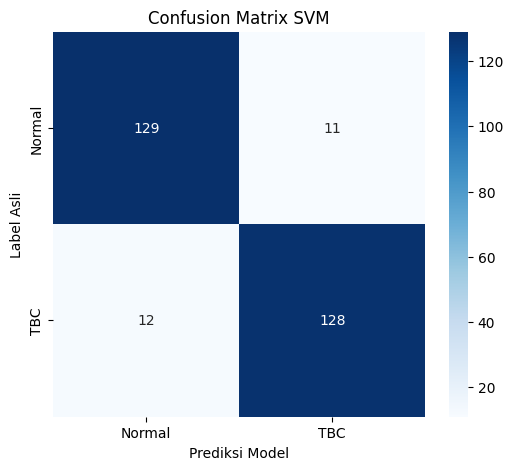

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import permutation_importance

# ==========================================
# 1. PERSIAPAN DATA & SPLITTING
# ==========================================

# Nama fitur sesuai urutan fungsi extract_features_final tadi
feature_names = [
    'Contrast (GLCM)', 'Homogeneity (GLCM)', 'Energy (GLCM)', 'Correlation (GLCM)', 'Entropy',
    'Mean Upper Zone', 'Mean Lower Zone', 'Zonal Ratio (Upper/Lower)',
    'Num Blobs (Nodules)', 'Edge Mean (Sharpness)'
]

# Split data: 80% Training, 20% Testing
# random_state=42 agar hasil konsisten setiap kali dijalankan
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

print(f"Data Training: {X_train.shape[0]} sampel")
print(f"Data Testing : {X_test.shape[0]} sampel")

# ==========================================
# 2. SCALING (WAJIB UNTUK SVM)
# ==========================================
scaler = StandardScaler()

# Fit scaler hanya pada data training (agar tidak ada kebocoran data dari testing)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 3. TRAINING SVM
# ==========================================
# Kernel 'rbf' biasanya paling bagus untuk data medis yang kompleks
# C=1.0 adalah standar, bisa dinaikkan jika ingin model lebih ketat (tapi risiko overfitting)
svm_model = SVC(kernel='rbf', C=100, gamma=0.01, random_state=42)
svm_model.fit(X_train_scaled, y_train)

print("\nModel SVM berhasil dilatih!")

# ==========================================
# 4. TESTING & EVALUASI
# ==========================================
y_pred = svm_model.predict(X_test_scaled)

print("\n=== CLASSIFICATION REPORT ===")
# Target names: 0 = Normal, 1 = TBC
print(classification_report(y_test, y_pred, target_names=['Normal', 'TBC']))

print(f"Akurasi Model: {accuracy_score(y_test, y_pred)*100:.2f}%")

# Visualisasi Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'TBC'], yticklabels=['Normal', 'TBC'])
plt.xlabel('Prediksi Model')
plt.ylabel('Label Asli')
plt.title('Confusion Matrix SVM')
plt.show()


=== RANKING FITUR ===
Homogeneity (GLCM): 0.3368
Mean Lower Zone: 0.2286
Energy (GLCM): 0.1950
Entropy: 0.1200
Contrast (GLCM): 0.1104
Edge Mean (Sharpness): 0.0982
Correlation (GLCM): 0.0950
Mean Upper Zone: 0.0746
Num Blobs (Nodules): 0.0339
Zonal Ratio (Upper/Lower): 0.0000


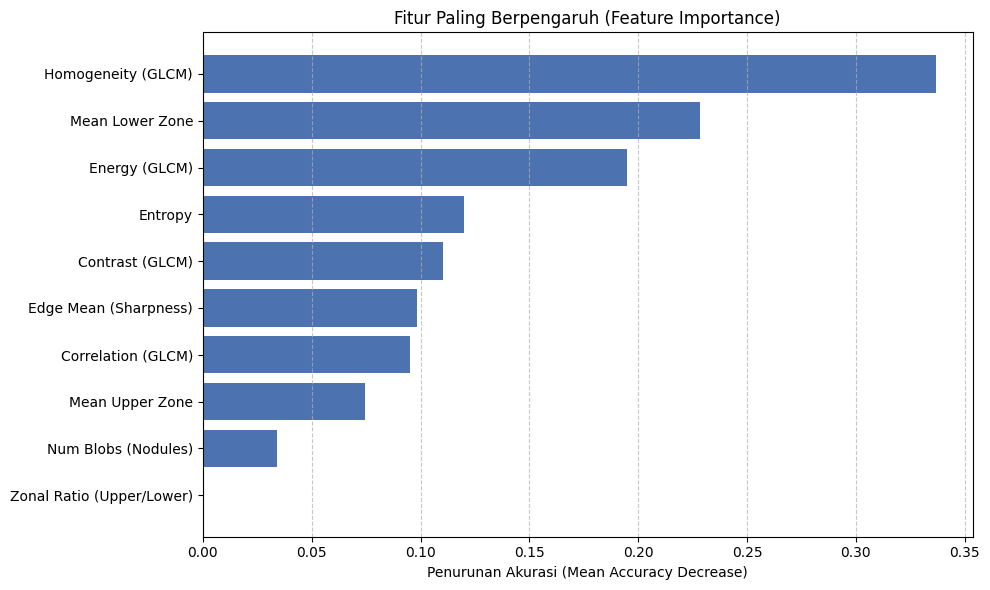

In [ ]:
# ==========================================
# 5. ANALISIS FITUR TERPENTING (Feature Importance)
# ==========================================

# Hitung Permutation Importance pada data Test
perm_importance = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Ambil nilai rata-rata importance
importances = perm_importance.importances_mean
sorted_idx = importances.argsort()

# Visualisasi Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center', color='#4c72b0')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Penurunan Akurasi (Mean Accuracy Decrease)")
plt.title("Fitur Paling Berpengaruh (Feature Importance)")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Tampilkan Angka
print("\n=== RANKING FITUR ===")
for i in sorted_idx[::-1]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")

plt.tight_layout()
plt.show()

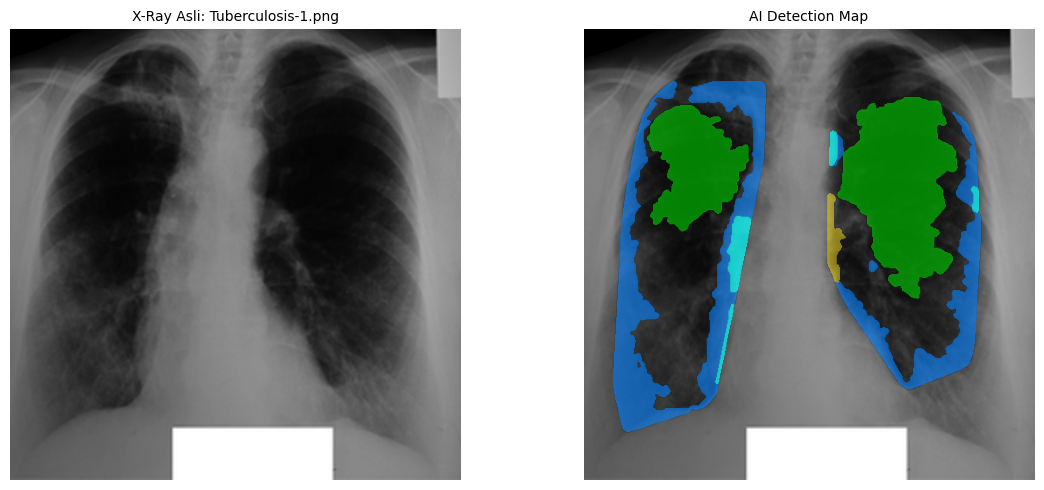

📋 LAPORAN DIAGNOSIS AI UNTUK: Tuberculosis-1.png
● [EFFUSION] - Area: 27.81%
  Warna Peta : Biru Laut
  Indikasi   : Cairan Pleura (Menutupi Sudut/Bawah Paru)
------------------------------------------------------------
● [INFILTRATE] - Area: 1.15%
  Warna Peta : Kuning
  Indikasi   : Bercak Sebar (Infeksi Awal/Aktif)
------------------------------------------------------------
● [CAVITY] - Area: 30.24%
  Warna Peta : Hijau
  Indikasi   : Lubang/Kerusakan Jaringan (TBC Lanjut)
------------------------------------------------------------
● [CALCIFICATION] - Area: 2.41%
  Warna Peta : Cyan/Biru Muda
  Indikasi   : Jaringan Keras (Bekas Luka Lama)
------------------------------------------------------------
⚠️ TOTAL AREA PARU TERINFEKSI: 61.61%
   Status: KONDISI KRITIS (High Severity)




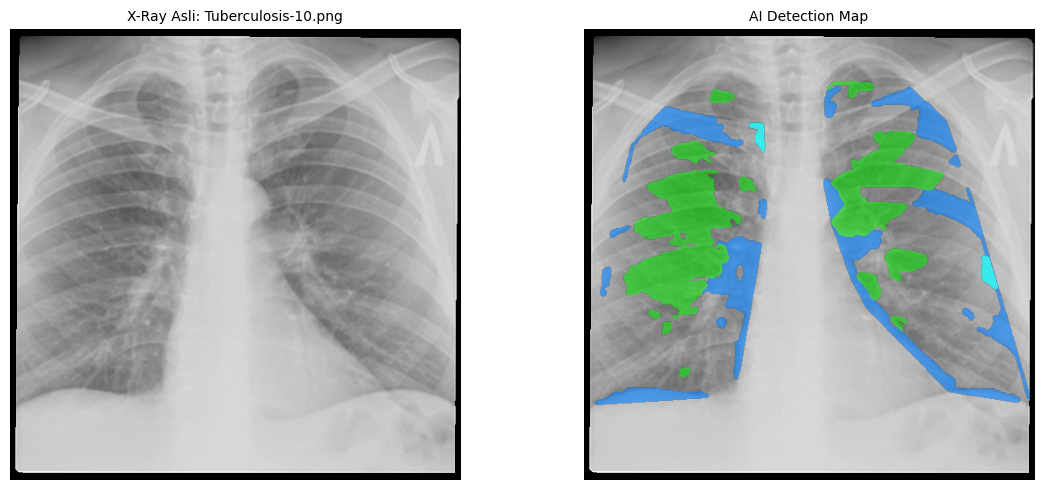

📋 LAPORAN DIAGNOSIS AI UNTUK: Tuberculosis-10.png
● [EFFUSION] - Area: 19.12%
  Warna Peta : Biru Laut
  Indikasi   : Cairan Pleura (Menutupi Sudut/Bawah Paru)
------------------------------------------------------------
● [CAVITY] - Area: 21.91%
  Warna Peta : Hijau
  Indikasi   : Lubang/Kerusakan Jaringan (TBC Lanjut)
------------------------------------------------------------
● [CALCIFICATION] - Area: 0.76%
  Warna Peta : Cyan/Biru Muda
  Indikasi   : Jaringan Keras (Bekas Luka Lama)
------------------------------------------------------------
⚠️ TOTAL AREA PARU TERINFEKSI: 41.78%
   Status: MODERATE (Perlu Penanganan Segera)




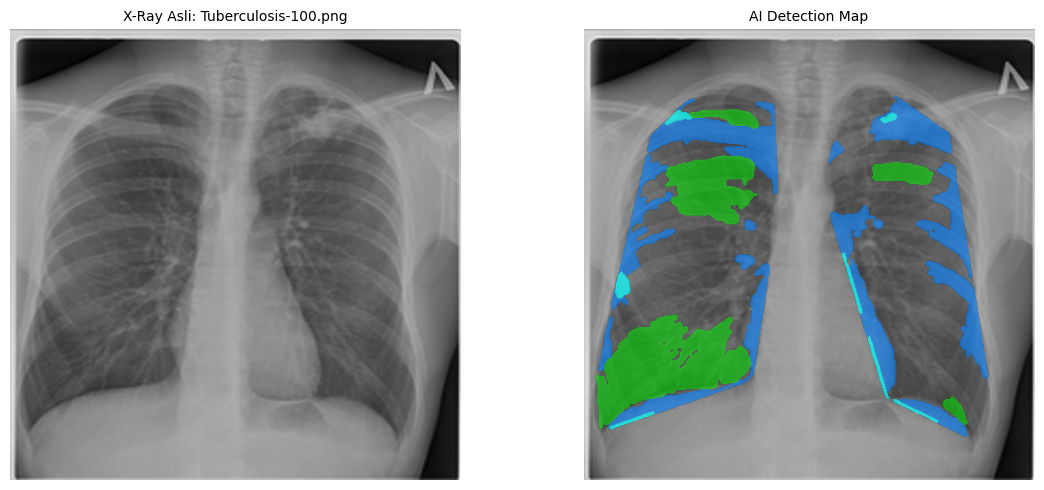

📋 LAPORAN DIAGNOSIS AI UNTUK: Tuberculosis-100.png
● [EFFUSION] - Area: 25.98%
  Warna Peta : Biru Laut
  Indikasi   : Cairan Pleura (Menutupi Sudut/Bawah Paru)
------------------------------------------------------------
● [CAVITY] - Area: 20.07%
  Warna Peta : Hijau
  Indikasi   : Lubang/Kerusakan Jaringan (TBC Lanjut)
------------------------------------------------------------
● [CALCIFICATION] - Area: 1.77%
  Warna Peta : Cyan/Biru Muda
  Indikasi   : Jaringan Keras (Bekas Luka Lama)
------------------------------------------------------------
⚠️ TOTAL AREA PARU TERINFEKSI: 47.82%
   Status: MODERATE (Perlu Penanganan Segera)




In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.segmentation import felzenszwalb
from skimage.measure import regionprops
from skimage import img_as_float
from scipy.ndimage import gaussian_filter
import os

# ==========================================
# 1. KONFIGURASI (MODIFIED: Effusion)
# ==========================================
LESION_CONFIG = {
    'Effusion': {  # <--- GANTI DARI CONSOLIDATION
        'color': [0.0, 0.5, 1.0, 0.6], # Biru Laut (Representasi Cairan)
        'color_name': 'Biru Laut',
        'desc': 'Cairan Pleura (Menutupi Sudut/Bawah Paru)',
        'id': 1
    },
    'Infiltrate': {
        'color': [1.0, 0.9, 0.1, 0.5], # Kuning
        'color_name': 'Kuning',
        'desc': 'Bercak Sebar (Infeksi Awal/Aktif)',
        'id': 2
    },
    'Cavity': {
        'color': [0.0, 1.0, 0.0, 0.5], # Hijau
        'color_name': 'Hijau',
        'desc': 'Lubang/Kerusakan Jaringan (TBC Lanjut)',
        'id': 3
    },
    'Calcification': {
        'color': [0.0, 1.0, 1.0, 0.7], # Cyan
        'color_name': 'Cyan/Biru Muda',
        'desc': 'Jaringan Keras (Bekas Luka Lama)',
        'id': 4
    }
}

# ==========================================
# 2. LOGIKA ANALISIS
# ==========================================
def analyze_and_overlay_final(img_original, lung_mask):
    img_float = img_as_float(img_original)
    img_masked = img_float.copy()
    img_masked[lung_mask == 0] = 0

    try:
        segments = felzenszwalb(img_masked, scale=40, sigma=0.5, min_size=50, channel_axis=None)
    except TypeError:
        segments = felzenszwalb(img_masked, scale=40, sigma=0.5, min_size=50)

    # Inisialisasi Masker sesuai Config baru
    masks = {k: np.zeros_like(img_original, dtype=float) for k in LESION_CONFIG.keys()}

    lung_pixels = img_original[lung_mask > 0]
    if len(lung_pixels) == 0: return None, {}

    global_mean = np.mean(lung_pixels)
    global_std = np.std(lung_pixels)
    h, w = img_original.shape

    unique_segments = np.unique(segments)

    for seg_id in unique_segments:
        if seg_id == 0: continue
        segment_mask = (segments == seg_id)
        if np.sum(segment_mask & lung_mask) / np.sum(segment_mask) < 0.6: continue

        patch_vals = img_original[segment_mask]
        mean_val = np.mean(patch_vals)
        variance = np.var(patch_vals)

        # Cek posisi (Centroid) untuk logika tambahan
        # Effusion biasanya di bawah, tapi kita pakai logika tekstur dulu
        r_coords, _ = np.where(segment_mask)
        # avg_row = np.mean(r_coords)

        # --- LOGIKA DETEKSI (UPDATED) ---

        # 1. Calcification (Sangat Putih & Kontras)
        if mean_val > (global_mean + 2.0 * global_std):
            masks['Calcification'][segment_mask] = 1.0

        # 2. EFFUSION (Ganti Consolidation)
        # Ciri: Putih (High Mean) dan Homogen/Cair (Low Variance)
        elif mean_val > (global_mean + 0.8 * global_std) and variance < 500:
            masks['Effusion'][segment_mask] = 1.0  # <--- MAPPING KE EFFUSION

        # 3. Cavity (Gelap / Lubang)
        elif mean_val < (global_mean - 0.9 * global_std):
            masks['Cavity'][segment_mask] = 1.0

        # 4. Infiltrate (Agak Putih & Kasar)
        elif mean_val > global_mean and variance >= 500:
            masks['Infiltrate'][segment_mask] = 1.0

    # Statistik & Overlay creation
    total_lung_area = np.sum(lung_mask)
    stats = {}

    final_overlay = np.zeros((h, w, 4), dtype=float)

    for name, config in LESION_CONFIG.items():
        # Smoothing agar terlihat cair/natural
        mask_smooth = gaussian_filter(masks[name], sigma=1.5)
        mask_binary = mask_smooth > 0.1

        pixel_count = np.sum(mask_binary)
        percentage = (pixel_count / total_lung_area) * 100
        stats[name] = percentage

        if percentage > 0.1:
            idx = mask_binary > 0
            final_overlay[idx] = config['color']

    return final_overlay, stats

# ==========================================
# 3. VISUALISASI DENGAN TEKS REPORT
# ==========================================

def visualize_text_report(tbc_dir, num_samples=3):
    if not os.path.exists(tbc_dir):
        print(f"Path {tbc_dir} tidak ditemukan.")
        return

    files = sorted(os.listdir(tbc_dir))[:num_samples]

    for i, fname in enumerate(files):
        fpath = os.path.join(tbc_dir, fname)

        # 1. Processing
        try:
            # Gunakan Segmentasi V4 Smart Fallback (Wajib agar tidak error)
            _, body_mask_eroded, body_img = segment_body_robust(fpath)
            img_input, _, lung_mask, _ = segment_lungs_smart_fallback(body_img, body_mask_eroded)

            if np.sum(lung_mask) < 500:
                print(f"⚠️ Skip {fname}: Segmentasi paru gagal.")
                continue

            # Analisis Lesi Baru (Effusion)
            overlay, stats = analyze_and_overlay_final(img_input, lung_mask)
            if overlay is None: continue

            # 2. Plotting
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))

            # Gambar Asli
            axes[0].imshow(img_input, cmap='gray')
            axes[0].set_title(f"X-Ray Asli: {fname}", fontsize=10)
            axes[0].axis('off')

            # Gambar Overlay
            axes[1].imshow(img_input, cmap='gray')
            axes[1].imshow(overlay)
            axes[1].set_title("AI Detection Map", fontsize=10)
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()

            # 3. PRINT REPORT
            print(f"📋 LAPORAN DIAGNOSIS AI UNTUK: {fname}")
            print("=" * 60)

            lesion_found = False
            total_infection = 0

            for name, score in stats.items():
                if score > 0.1:
                    lesion_found = True
                    total_infection += score
                    color_name = LESION_CONFIG[name]['color_name']
                    desc = LESION_CONFIG[name]['desc']

                    print(f"● [{name.upper()}] - Area: {score:.2f}%")
                    print(f"  Warna Peta : {color_name}")
                    print(f"  Indikasi   : {desc}")
                    print("-" * 60)

            if not lesion_found:
                print("✅ Tidak ditemukan tanda lesi TBC yang signifikan.")
            else:
                print(f"⚠️ TOTAL AREA PARU TERINFEKSI: {total_infection:.2f}%")
                if total_infection > 50:
                    print("   Status: KONDISI KRITIS (High Severity)")
                elif total_infection > 20:
                    print("   Status: MODERATE (Perlu Penanganan Segera)")
                else:
                    print("   Status: MILD (Infeksi Ringan/Awal)")

            print("\n" + "="*80 + "\n")

        except Exception as e:
            print(f"❌ Error pada {fname}: {e}")

# JALANKAN
if 'tbc_path' in locals() and os.path.exists(tbc_path):
    visualize_text_report(tbc_path, num_samples=3)
else:
    print("Path 'tbc_path' belum diset.")

=== SISTEM DIAGNOSIS TBC OTOMATIS ===
Silakan upload file X-Ray (JPG/PNG) dari komputer Anda.


Saving TB.2028.jpg to TB.2028.jpg

🔍 Menganalisis citra: TB.2028.jpg...


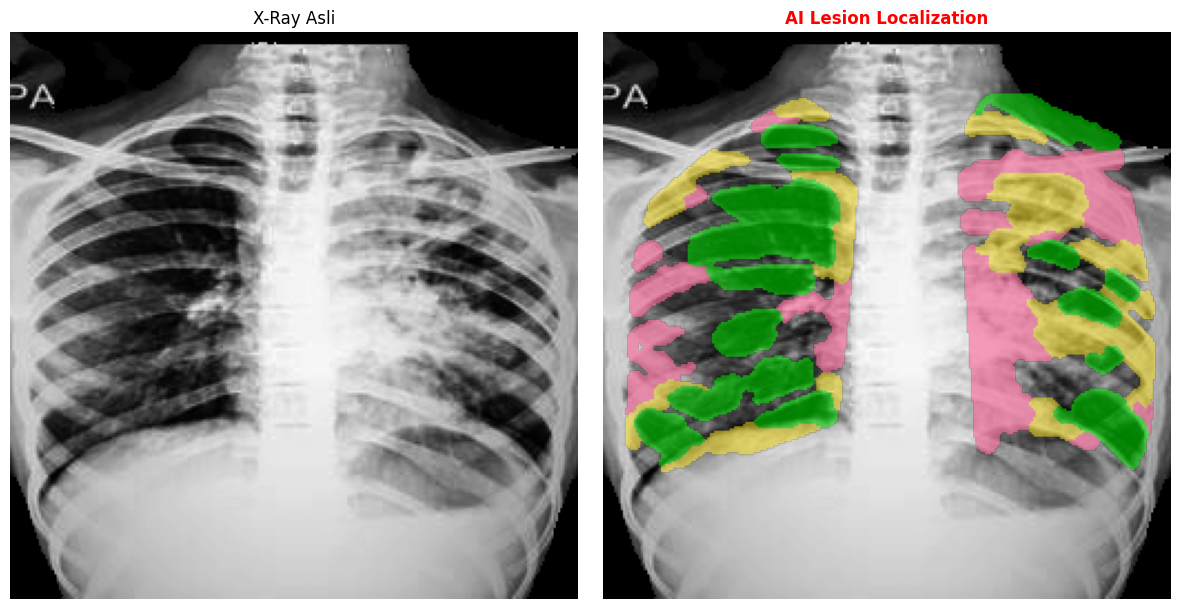


!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
⚠️ HASIL DIAGNOSIS: TERINDIKASI TUBERCULOSIS (TBC)
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

📋 DETAIL ANALISIS LESI:
--------------------------------------------------
● Consolidation   : 28.37% Area Paru
  [Warna: Pink] -> Area Padat/Cairan (Pneumonia/TBC Aktif)
--------------------------------------------------
● Infiltrate      : 26.19% Area Paru
  [Warna: Kuning] -> Bercak Sebar (Infeksi Awal/Aktif)
--------------------------------------------------
● Cavity          : 30.02% Area Paru
  [Warna: Hijau] -> Lubang/Kerusakan Jaringan (TBC Lanjut)
--------------------------------------------------

📈 TOTAL KEPARAHAN (SEVERITY): 84.58%
   Status: 🔴 HIGH RISK / LANJUT




In [ ]:
from google.colab import files
from PIL import Image
import cv2
import io

# ==========================================
# FUNGSI DIAGNOSIS TUNGGAL
# ==========================================

def diagnose_patient(image_path, model, scaler):
    """
    Pipeline Lengkap: Load -> Segment -> Extract -> Predict -> Visualize
    """
    print(f"\n🔍 Menganalisis citra: {os.path.basename(image_path)}...")

    # 1. PREPROCESSING & SEGMENTASI
    try:
        # Load Image
        _, body_mask, body_img = segment_body_robust(image_path)
        img_input, _, lung_mask, final_img = segment_lungs_smart_fallback(body_img, body_mask)

        # Cek kegagalan segmentasi
        if np.sum(lung_mask) < 500:
            print("❌ Gagal mendeteksi paru-paru. Pastikan kualitas X-Ray baik.")
            return

        # 2. EKSTRAKSI FITUR (Untuk SVM)
        features = extract_features_final(final_img)

        # Handle NaN
        features = np.nan_to_num(features).tolist()

        # 3. KLASIFIKASI (SVM)
        # Scaling fitur (WAJIB sama dengan saat training)
        features_scaled = scaler.transform([features])

        # Prediksi
        prediction = model.predict(features_scaled)[0]
        # Jika model support probability (optional check)
        # proba = model.predict_proba(features_scaled)[0]

    except Exception as e:
        print(f"❌ Error saat pemrosesan: {e}")
        return

    # ==========================================
    # 4. VISUALISASI HASIL
    # ==========================================

    # SKENARIO A: NORMAL
    if prediction == 0:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(img_input, cmap='gray')
        axes[0].set_title("X-Ray Asli")
        axes[0].axis('off')

        axes[1].imshow(final_img, cmap='gray')
        axes[1].set_title("Segmentasi Paru")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        print("\n✅ HASIL DIAGNOSIS: NORMAL")
        print("   Paru-paru tampak bersih. Tidak ditemukan indikator TBC yang signifikan.")
        print("   (Note: Selalu konsultasikan dengan dokter untuk kepastian 100%)")

    # SKENARIO B: TBC (TUBERCULOSIS)
    else:
        # Jalankan Analisis Lesi Mendalam
        overlay, stats = analyze_and_overlay_final(img_input, lung_mask)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Gambar 1: Input
        axes[0].imshow(img_input, cmap='gray')
        axes[0].set_title("X-Ray Asli", fontsize=12)
        axes[0].axis('off')

        # Gambar 2: AI Map
        axes[1].imshow(img_input, cmap='gray')
        axes[1].imshow(overlay)
        axes[1].set_title("AI Lesion Localization", fontsize=12, fontweight='bold', color='red')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        # PRINT REPORT
        print("\n" + "!"*60)
        print("⚠️ HASIL DIAGNOSIS: TERINDIKASI TUBERCULOSIS (TBC)")
        print("!"*60)

        print("\n📋 DETAIL ANALISIS LESI:")
        print("-" * 50)

        total_severity = 0
        found_lesion = False

        for name, score in stats.items():
            if score > 0.1: # Threshold tampil
                found_lesion = True
                total_severity += score

                # Info Warna & Deskripsi
                c_name = LESION_CONFIG[name]['color_name']
                desc = LESION_CONFIG[name]['desc']

                print(f"● {name.ljust(15)} : {score:.2f}% Area Paru")
                print(f"  [Warna: {c_name}] -> {desc}")
                print("-" * 50)

        if not found_lesion:
            print("   (Model memprediksi TBC berdasarkan tekstur global,")
            print("    namun lesi spesifik terlalu kecil untuk divisualisasikan)")
        else:
            print(f"\n📈 TOTAL KEPARAHAN (SEVERITY): {total_severity:.2f}%")
            if total_severity > 40:
                print("   Status: 🔴 HIGH RISK / LANJUT")
            elif total_severity > 15:
                print("   Status: 🟠 MODERATE RISK")
            else:
                print("   Status: 🟡 LOW RISK / AWAL")

# ==========================================
# 5. INPUT UPLOAD (USER INTERFACE)
# ==========================================

print("=== SISTEM DIAGNOSIS TBC OTOMATIS ===")
print("Silakan upload file X-Ray (JPG/PNG) dari komputer Anda.")

uploaded = files.upload()

for fn in uploaded.keys():
    # Simpan file sementara agar bisa dibaca path-nya
    path = fn
    # Panggil fungsi diagnosis
    diagnose_patient(path, svm_model, scaler)
    print("\n" + "="*50 + "\n")

=== SISTEM DIAGNOSIS TBC OTOMATIS ===
Silakan upload file X-Ray (JPG/PNG) dari komputer Anda.


Saving others (147).jpg to others (147).jpg

🔍 Menganalisis citra: others (147).jpg...


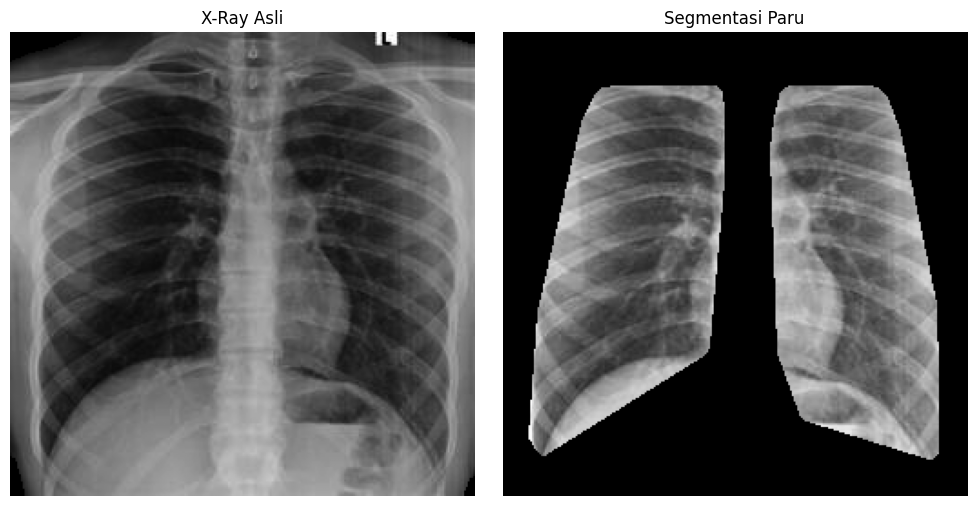


✅ HASIL DIAGNOSIS: NORMAL
   Paru-paru tampak bersih. Tidak ditemukan indikator TBC yang signifikan.
   (Note: Selalu konsultasikan dengan dokter untuk kepastian 100%)




In [ ]:
from google.colab import files
from PIL import Image
import cv2
import io

# ==========================================
# FUNGSI DIAGNOSIS TUNGGAL
# ==========================================

def diagnose_patient(image_path, model, scaler):
    """
    Pipeline Lengkap: Load -> Segment -> Extract -> Predict -> Visualize
    """
    print(f"\n🔍 Menganalisis citra: {os.path.basename(image_path)}...")

    # 1. PREPROCESSING & SEGMENTASI
    try:
        # Load Image
        _, body_mask, body_img = segment_body_robust(image_path)
        img_input, _, lung_mask, final_img = segment_lungs_smart_fallback(body_img, body_mask)

        # Cek kegagalan segmentasi
        if np.sum(lung_mask) < 500:
            print("❌ Gagal mendeteksi paru-paru. Pastikan kualitas X-Ray baik.")
            return

        # 2. EKSTRAKSI FITUR (Untuk SVM)
        features = extract_features_final(final_img)

        # Handle NaN
        features = np.nan_to_num(features).tolist()

        # 3. KLASIFIKASI (SVM)
        # Scaling fitur (WAJIB sama dengan saat training)
        features_scaled = scaler.transform([features])

        # Prediksi
        prediction = model.predict(features_scaled)[0]
        # Jika model support probability (optional check)
        # proba = model.predict_proba(features_scaled)[0]

    except Exception as e:
        print(f"❌ Error saat pemrosesan: {e}")
        return

    # ==========================================
    # 4. VISUALISASI HASIL
    # ==========================================

    # SKENARIO A: NORMAL
    if prediction == 0:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        axes[0].imshow(img_input, cmap='gray')
        axes[0].set_title("X-Ray Asli")
        axes[0].axis('off')

        axes[1].imshow(final_img, cmap='gray')
        axes[1].set_title("Segmentasi Paru")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        print("\n✅ HASIL DIAGNOSIS: NORMAL")
        print("   Paru-paru tampak bersih. Tidak ditemukan indikator TBC yang signifikan.")
        print("   (Note: Selalu konsultasikan dengan dokter untuk kepastian 100%)")

    # SKENARIO B: TBC (TUBERCULOSIS)
    else:
        # Jalankan Analisis Lesi Mendalam
        overlay, stats = analyze_and_overlay_final(img_input, lung_mask)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        # Gambar 1: Input
        axes[0].imshow(img_input, cmap='gray')
        axes[0].set_title("X-Ray Asli", fontsize=12)
        axes[0].axis('off')

        # Gambar 2: AI Map
        axes[1].imshow(img_input, cmap='gray')
        axes[1].imshow(overlay)
        axes[1].set_title("AI Lesion Localization", fontsize=12, fontweight='bold', color='red')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

        # PRINT REPORT
        print("\n" + "!"*60)
        print("⚠️ HASIL DIAGNOSIS: TERINDIKASI TUBERCULOSIS (TBC)")
        print("!"*60)

        print("\n📋 DETAIL ANALISIS LESI:")
        print("-" * 50)

        total_severity = 0
        found_lesion = False

        for name, score in stats.items():
            if score > 0.1: # Threshold tampil
                found_lesion = True
                total_severity += score

                # Info Warna & Deskripsi
                c_name = LESION_CONFIG[name]['color_name']
                desc = LESION_CONFIG[name]['desc']

                print(f"● {name.ljust(15)} : {score:.2f}% Area Paru")
                print(f"  [Warna: {c_name}] -> {desc}")
                print("-" * 50)

        if not found_lesion:
            print("   (Model memprediksi TBC berdasarkan tekstur global,")
            print("    namun lesi spesifik terlalu kecil untuk divisualisasikan)")
        else:
            print(f"\n📈 TOTAL KEPARAHAN (SEVERITY): {total_severity:.2f}%")
            if total_severity > 40:
                print("   Status: 🔴 HIGH RISK / LANJUT")
            elif total_severity > 15:
                print("   Status: 🟠 MODERATE RISK")
            else:
                print("   Status: 🟡 LOW RISK / AWAL")

# ==========================================
# 5. INPUT UPLOAD (USER INTERFACE)
# ==========================================

print("=== SISTEM DIAGNOSIS TBC OTOMATIS ===")
print("Silakan upload file X-Ray (JPG/PNG) dari komputer Anda.")

uploaded = files.upload()

for fn in uploaded.keys():
    # Simpan file sementara agar bisa dibaca path-nya
    path = fn
    # Panggil fungsi diagnosis
    diagnose_patient(path, svm_model, scaler)
    print("\n" + "="*50 + "\n")

In [42]:
import joblib
from google.colab import files

# ==========================================
# 1. SIMPAN MODEL & SCALER
# ==========================================

print("💾 Sedang menyimpan model ke file .pkl...")

# Pastikan variabel svm_model dan scaler sudah ada (dari proses training sebelumnya)
if 'svm_model' in locals() and 'scaler' in locals():

    # Simpan Model
    joblib.dump(svm_model, 'svm_model_tbc_final.pkl')
    print("✅ Model tersimpan: svm_model_tbc_final.pkl")

    # Simpan Scaler (SANGAT PENTING)
    joblib.dump(scaler, 'scaler_tbc_final.pkl')
    print("✅ Scaler tersimpan: scaler_tbc_final.pkl")

    print("\n⬇️ Mengunduh file ke komputer Anda...")

    # Download otomatis (Khusus Google Colab)
    try:
        files.download('svm_model_tbc_final.pkl')
        files.download('scaler_tbc_final.pkl')
    except Exception as e:
        print("⚠️ Gagal download otomatis. Silakan download manual di tab 'Files' sebelah kiri.")

else:
    print("❌ Error: Variabel 'svm_model' atau 'scaler' tidak ditemukan.")
    print("   Pastikan Anda sudah menjalankan kode Training SVM di atas!")

💾 Sedang menyimpan model ke file .pkl...
✅ Model tersimpan: svm_model_tbc_final.pkl
✅ Scaler tersimpan: scaler_tbc_final.pkl

⬇️ Mengunduh file ke komputer Anda...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>